## Task1.1

In [4]:
#imports for reading the text and csv files
import pandas as pd
import os
import io

#read the csv file "case_reversed"
data = pd.read_csv('data/case_reversed.csv')[['caseid', 'case_reversed']]

data.head()

,caseid,case_reversed
0,X3JGGO,0
1,X3OH3J,0
2,X3U0KO,0
3,X53HAD,0
4,X9VC5V,0


In [5]:
n = 200

#sample n cases at random
from random import shuffle

keep = [True] * n + [False] * (len(data) - n)
shuffle(keep)
data = data[keep]

data.head()

,caseid,case_reversed
41,X9UE16,0
58,X498PJ,0
68,X3GD3G,0
73,X3G5B1,0
164,X3S7PG,0


In [6]:
#NOTE: Sometimes the reader can't decode a special sign in one of the cases. If this error occurs just run it again

#definitions
def find_filename(case):
    "finds the filename according to caseid"
    for i in range(1924, 2019):
        if os.path.isfile("data/cases/"+str(i)+"_"+case+".txt"):
            return str(i)+"_"+case+".txt"

    print("File not found error!")
    return ""

def get_year(filename):
    "returns the year according to filename"
    return filename[:4]

def load_text(filename):
    "loads the .txt file"
    ff = io.open('data/cases/' + filename)
    txt = ff.read()
    ff.close()
    return txt

def run_spacy(txt):
    "runns spaCy over the txt file"
    return nlp(txt)
#/definitions

#import SpaCy for textanalysis in english
import spacy
nlp = spacy.load('en')

#find the filename of each case
data['filename'] = data['caseid'].apply(find_filename)

#get the corresponding year
data['year']= data['filename'].apply(get_year)

#load the text form the file
data['text'] = data['filename'].apply(load_text)

#save dataframe with text documents as csv file
#data.to_csv('data_with_text_'+str(n)+'.csv')

data[['filename','year','text']].head()


#NOTE: Sometimes the reader can't decode a special sign in one of the cases. If this error occurs just run it again

,filename,year,text
41,1926_X9UE16.txt,1926,"ANDERSON , Circuit Judge.\nThis is an appeal ..."
58,1928_X498PJ.txt,1928,"SWAN , Circuit Judge.\nThe relief sought on t..."
68,1929_X3GD3G.txt,1929,"STONE , Circuit Judge.\nThis is an action (fi..."
73,1929_X3G5B1.txt,1929,PER CURIAM.\nDecree [ 31 F.(2d) 496 ] affirme...
164,1932_X3S7PG.txt,1932,"WILBUR , Circuit Judge.\nDuring the life of a..."


In [7]:
#definitions
def get_num_sents(doc):
    "return number of sentences from spacy document"
    return len(list(doc.sents))

def get_num_tokens(doc):
    "return number of tokens from spacy document"
    return len(doc)
#/definitions

#apply SpaCy to every text
data['doc']= data['text'].apply(run_spacy)

#get number of sentences per case
data['num_sents'] = data['doc'].apply(get_num_sents)

#get number of tokens per case
data['num_tokens'] = data['doc'].apply(get_num_tokens)

#get number of letters per case
data['num_chars'] = data['text'].str.len() # use pandas built-in function on plain text

data[['num_sents','num_tokens','num_chars']].head()

,num_sents,num_tokens,num_chars
41,55,1781,8750
58,114,3198,15801
68,41,1388,6989
73,2,15,48
164,70,2434,12444


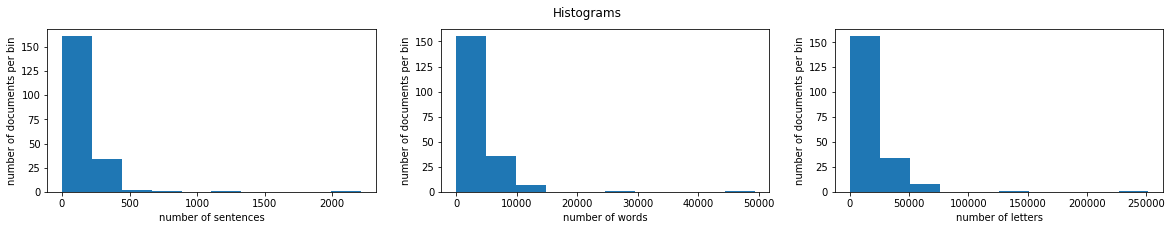

In [27]:
#import pyplot
import matplotlib.pyplot as plt

#create a figure 
plt.figure(1, figsize=(20, 3))

plt.subplot(131)
plt.hist(data['num_sents'])
plt.ylabel('number of documents per bin')
plt.xlabel('number of sentences')
plt.subplot(132)
plt.hist(data['num_tokens'])
plt.ylabel('number of documents per bin')
plt.xlabel('number of words')
plt.subplot(133)
plt.hist(data['num_chars'])
plt.ylabel('number of documents per bin')
plt.xlabel('number of letters')
plt.suptitle('Histograms')
plt.show()

# # Task 1.2

In [9]:
#definitions
def count_nouns(doc):
    "count number of nouns in each document"
    return len([w for w in doc if w.tag_.startswith('N')])
def count_adjectives(doc):
    "count number of adjectives in each document"
    return len([w for w in doc if w.tag_.startswith('J')])
def count_verbs(doc):
    "count number of verbs in each document"
    return len([w for w in doc if w.tag_.startswith('V')])
#/definitions

#count nouns
data['num_nouns'] = data['doc'].apply(count_nouns)

#count adjectives
data['num_adjectives'] = data['doc'].apply(count_adjectives)

#count verbs
data['num_verbs'] = data['doc'].apply(count_verbs)

data[['num_nouns','num_adjectives','num_verbs']].head()

,num_nouns,num_adjectives,num_verbs
41,440,61,243
58,892,112,404
68,355,62,167
73,4,0,1
164,596,118,312


In [10]:
#compute noun frequency
data['noun_freq'] = data['num_nouns'] / data['num_tokens']

#compute adjective freqiency
data['adjective_freq'] = data['num_adjectives'] / data['num_tokens']

#compute verb frequency
data['verb_freq'] = data['num_verbs'] / data['num_tokens']

data[['noun_freq','adjective_freq','verb_freq']].head()

,noun_freq,adjective_freq,verb_freq
41,0.247052,0.034250,0.136440
58,0.278924,0.035022,0.126329
68,0.255764,0.044669,0.120317
73,0.266667,0.000000,0.066667
164,0.244864,0.048480,0.128184


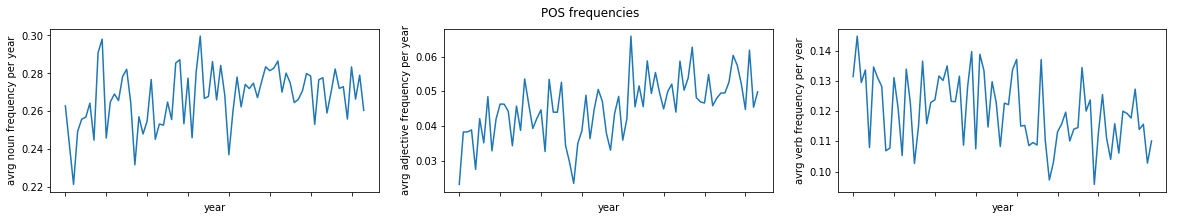

In [11]:
#create figure
plt.figure(1, figsize=(20, 3))

plt.subplot(131)
data.groupby('year')['noun_freq'].mean().plot()
plt.ylabel('avrg noun frequency per year')
plt.subplot(132)
data.groupby('year')['adjective_freq'].mean().plot()
plt.ylabel('avrg adjective frequency per year')
plt.subplot(133)
data.groupby('year')['verb_freq'].mean().plot()
plt.ylabel('avrg verb frequency per year')
plt.suptitle('POS frequencies')
plt.show()

## Task 1.3

In [12]:
#imports
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk import ngrams

#definitions
def normalize_and_tag_text(doc):
    "Input spacy doc and return clean list of pairs (tokens, tag) "
    tokens = []
    for token in doc:
        if not token.is_punct and not token.is_stop and not token.is_space:
            tagged_token = (str(token.lower_), token.tag_)
            if tagged_token[0].isdigit():
                tagged_token = ("#", tagged_token[1])
                
            tagged_token = (stemmer.stem(tagged_token[0]), tagged_token[1])
            tokens.append(tagged_token)
    return tokens

def get_trigrams(tokens):
    "returns list of all trigrams that end in a noun per case"
    trigrams = [trigram for trigram in ngrams(tokens,3) if trigram[2][1].startswith('N')]
    return [a1 + '_' + b1 + '_' + c1 for ((a1, a2), (b1, b2), (c1, c2)) in trigrams]
   
#/definitions

#normalize SpaCy doc
data['tokens_cleaned_tagged'] = data['doc'].apply(normalize_and_tag_text)

#get all trigrams per case
data['trigrams'] = data['tokens_cleaned_tagged'].apply(get_trigrams)

#save trigrams in a csv file
#data['trigrams'].to_csv('trigrams_'+str(n)+'.csv', index = False, header = 'trigrams')

data['trigrams'].head()

41     [anderson_circuit_judg, judg_this_appeal, this...
58     [swan_circuit_judg, judg_the_relief, relief_so...
68     [stone_circuit_judg, judg_this_action, action_...
73                     [per_curiam_decre, decre_#_f.(2d]
164    [wilbur_circuit_judg, judg_dure_life, $_10,000...
Name: trigrams, dtype: object

## Task 1.4

In [13]:
def clean_trigrams(trigram_list, trigramFeatures):
    "creates a list that only includes trigrams from the featurelist"
    newlist =[]
    for trigram in trigram_list:
        if trigram in trigramFeatures:
            newlist.append(trigram)
    return newlist

from collections import Counter
trigrams_frequencies = Counter()

#count the number of distinct trigrams
for trigram_list in data['trigrams']:
    for trigram in trigram_list:
        trigrams_frequencies.update({trigram : 1})

#select the 2000 most frequent trigrams as features
trigramFeatures = sorted([x[0] for x in trigrams_frequencies.most_common()[:2000]])

print(trigramFeatures[:10])

['#_#_11th', '#_#_3d', '#_#_8th', '#_#_a.', '#_#_a.l.r.', '#_#_accord', '#_#_act', '#_#_agent', '#_#_am', '#_#_amtrak']


In [14]:
#sort out all the unimportant trigrams per case
data['clean_trigrams'] = data['trigrams'].apply(clean_trigrams, trigramFeatures = trigramFeatures)

data['clean_trigrams'].head()

41     [judg_this_appeal, evid_record_case, on_appeal...
58     [motion_preliminari_injunct, suprem_court_stat...
68     [c._c._a., a._#_f.(2d, war_risk_insur, #_#_pla...
73                                                    []
164    [war_risk_insur, risk_insur_polici, #_on_march...
Name: clean_trigrams, dtype: object

In [15]:
#count per case how often a feature trigram appears
cleaned_freqs = []
for trigram_list in data['clean_trigrams']:
    cleaned_freqs.append(Counter(trigram_list)) # make a counter for each row

#create dataframe with the cleaed feature frequencies
features = pd.DataFrame(cleaned_freqs)

print(features[:5])

   #_#_11th  #_#_3d  #_#_8th  #_#_a.  #_#_a.l.r.  #_#_accord  #_#_act  \
0       NaN     NaN      NaN     NaN         NaN         NaN      NaN   
1       NaN     NaN      NaN     3.0         NaN         NaN      NaN   
2       NaN     NaN      NaN     NaN         NaN         NaN      NaN   
3       NaN     NaN      NaN     NaN         NaN         NaN      NaN   
4       NaN     NaN      NaN     NaN         NaN         NaN      NaN   

   #_#_agent  #_#_am  #_#_amtrak       ...         worker_#_f.2d  \
0        NaN     NaN         NaN       ...                   NaN   
1        NaN     3.0         NaN       ...                   NaN   
2        NaN     NaN         NaN       ...                   NaN   
3        NaN     NaN         NaN       ...                   NaN   
4        NaN     NaN         NaN       ...                   NaN   

   workmen_'s_compens  wright_v._vinton  writ_certiorari_suprem  \
0                 NaN               NaN                     NaN   
1                 

In [16]:
#replace NaN's with 0's
features.fillna(0,inplace=True)

#scale to unit variance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean = False)
scaler.fit(features)
scaledfeatures = scaler.transform(features)

print(scaledfeatures)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         4.31230818 ... 0.         0.         0.        ]]


## Task 1.5

In [17]:
#SILENCE WARNINGS
import warnings
warnings.filterwarnings('ignore')

#create a test and training set while linking data to the 'case_reversed' bit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaledfeatures, data['case_reversed'], test_size=0.2)

#use LogisticRegression for case prediction
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

#predict on test and training data
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

#compute score and F1 score
from sklearn.metrics import f1_score
print('Training set: F1 = ' + str(f1_score(y_train, y_pred_train)) + ' ; score = ' + str(clf.score(X_train, y_train)))
print('Test set: F1 = ' + str(f1_score(y_test, y_pred_test)) + ' ; score = ' + str(clf.score(X_test, y_test)))


Training set: F1 = 0.9908256880733944 ; score = 0.9875
Test set: F1 = 0.7999999999999999 ; score = 0.7


## Task 1.6

In [18]:
#import GridSearchCV and use it to find best parameters for Logistic regression
from sklearn.model_selection import GridSearchCV
import numpy as np

#define Parameters do search for the best combination
parameters = {'penalty':('l1', 'l2'), 'C':list(np.logspace(-6, 0, num = 1000))}

#find best parameters
gscv = GridSearchCV(clf, parameters, cv=5)
gscv.fit(X_train, y_train)
params = gscv.best_params_
print('With the GridSearchCV function we get the following parameters:')
print(params)
print('score: ' + str(gscv.best_score_))

With the GridSearchCV function we get the following parameters:
{'C': 3.5444556739704355e-05, 'penalty': 'l2'}
score: 0.69375


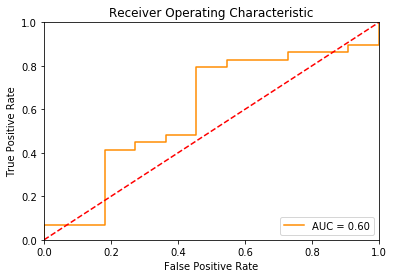

This result can vary when executing the notebook again from start, because there are two randomized steps:
1) selecting n cases at random.
2) random split of data in training and test set


In [19]:
#choose prediction with better score
if gscv.best_score_ < clf.score(X_test, y_test):
    probs = clf.predict_proba(X_test)
else:
    probs = gscv.predict_proba(X_test)

from sklearn import metrics
#get falsepositive-rate and truepositive-rate
fpr, tpr, threshold = metrics.roc_curve(y_test, probs[:,1])

#compute AUC
roc_auc = metrics.auc(fpr, tpr)

#plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('This result can vary when executing the notebook again from start, because there are two randomized steps:\n1) selecting n cases at random.\n2) random split of data in training and test set')

## Task 1.7

In [20]:
from nltk import tokenize

def get_sents_from_txt(txt, sents, sentsWithComp):
    "adds sentences to list 'sents' and adds tuple (compound score, sentence) to list 'sentsWithComp'"
    lines_list = tokenize.sent_tokenize(txt)
    for line in lines_list:
        ss = sid.polarity_scores(line)
        sentsWithComp.append((ss['compound'],line))
    sents.extend(lines_list)

#create list with sentence and list with compound score per sentence
sents=[]
sentsWithComp = []

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

data['text'].apply(get_sents_from_txt, sents= sents, sentsWithComp = sentsWithComp)

print(*sents[:5], sep = "\n")
print(*sentsWithComp[:5], sep = "\n")


 ANDERSON , Circuit Judge.
This is an appeal from a decree upon an accounting in a patent suit.
Only such evidence as bore upon that matter should have been heard by the master or the court below, and only such evidence should have been made part of the record "in case of appeal," and this only in the way the law prescribes.
On appeal this court, in a sense, hears the case de novo, but it must not be forgotten that it hears it, not as a trial, but as a reviewing, court.
The case is heard here upon such parts of the record, made in the court below, as the parties deem necessary to review certain questions raised and decided there.
(0.0, ' ANDERSON , Circuit Judge.')
(0.0, 'This is an appeal from a decree upon an accounting in a patent suit.')
(-0.2263, 'Only such evidence as bore upon that matter should have been heard by the master or the court below, and only such evidence should have been made part of the record "in case of appeal," and this only in the way the law prescribes.')
(0.2

In [21]:
#sort the sentences according to the compound score
sentsWithComp = sorted(sentsWithComp)

#print the 10 most positive sentences
for (score, sent) in sentsWithComp[-10:]:
    print('score: ' + str(score) + ' | sentence: ' + sent[:50] + '...')

score: 0.9612 | sentence: Indeed, it would require a particularly convoluted...
score: 0.9623 | sentence: The Guilford County case is remanded to the United...
score: 0.965 | sentence: It does not protect "inhabitants", but only "any c...
score: 0.9674 | sentence: For the purposes of the merger the value of the ti...
score: 0.9716 | sentence: To support these contentions, he relies on: (1) a ...
score: 0.9738 | sentence: They are: (1) the plan's compliance with Title 11,...
score: 0.9764 | sentence: The items of surcharges recommended by the Special...
score: 0.9801 | sentence: in the amount of $4,000, and that the remaining pl...
score: 0.9826 | sentence: Defendant contends that construing subdivision (a)...
score: 0.9845 | sentence: 6 After analyzing these Fromson factors, the distr...


In [ ]:
#print the 10 most negative sentences
for (score, sent) in sentsWithComp[:10]:
    print('score: ' + str(score) + ' | sentence: ' + sent[:50] + '...')

## Task 1.8

In [23]:
#compute TF-IDF score for every sentence
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(sents)

score = np.sum(X, axis=1)
for i in range(0,5):
    print('score: ' + str(score[i]) + '\nsentence: ' + sents[i] +'\n')

score: [[1.70454127]]
sentence:  ANDERSON , Circuit Judge.

score: [[3.13100601]]
sentence: This is an appeal from a decree upon an accounting in a patent suit.

score: [[5.02556063]]
sentence: Only such evidence as bore upon that matter should have been heard by the master or the court below, and only such evidence should have been made part of the record "in case of appeal," and this only in the way the law prescribes.

score: [[3.85820795]]
sentence: On appeal this court, in a sense, hears the case de novo, but it must not be forgotten that it hears it, not as a trial, but as a reviewing, court.

score: [[4.78941295]]
sentence: The case is heard here upon such parts of the record, made in the court below, as the parties deem necessary to review certain questions raised and decided there.



In [24]:
#compute pairwise cosine similarity of the sentences
from sklearn.metrics.pairwise import cosine_similarity
cosineMatrix = cosine_similarity(X)
print(cosineMatrix)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.10731418 ... 0.         0.         0.10087374]
 [0.         0.10731418 1.         ... 0.         0.09178764 0.05413839]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.09178764 ... 0.         1.         0.17837084]
 [0.         0.10087374 0.05413839 ... 0.         0.17837084 1.        ]]


In [30]:
#print similar and dissimilar sentence to sentence 5
#print(cosineMatrix[5])
print('The smilarity and dissimilarity is chosen numerically. Since most of the sentences are not similar to each other there can be the case that no similar sentences are found.\n\n')

print('Find similiar and dissimilar sentences to the following sentence:\n' +sents[10] + '\n')

print('SIMILAR \n')

for i in range(0, 20000):
    if 1.0 > cosineMatrix[10][i] >= 0.25:
        if len(sents[i]) > 50:
            print(sents[i] + '\n')

print('DISSIMILAR \n')

for i in range(0, 50):
    if 0.005 > cosineMatrix[10][i] >= 0.0:
        if len(sents[i]) > 50:
            print(sents[i] + '\n')

The smilarity and dissimilarity is chosen numerically. Since most of the sentences are not similar to each other there can be the case that no similar sentences are found.


Find similiar and dissimilar sentences to the following sentence:
This is signed by the District Judge.

SIMILAR 

The court admitted in evidence a statement signed by defendant Tessen made on May 4, 1934, the date the indictment herein was returned.

A witness for the appellee testified that at the time the merger agreement was signed there was no plan for the disposition of the two plants.

He complains that the order was not signed or verified in accordance with Rule 11, F.R.C.P.

A stay application was then filed by appellant before the District Judge.

The opinions of District Judge LaBuy in the District Court in this case and Circuit Judge Kerner in the Court of Appeals each cover less than two printed pages.

It is true that when this case was heard by the District Judge, the appellee was the only manufactur

## Task 1.9

In [31]:
#Use KMeans to cluster the sentences into 20 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, n_init = 20, max_iter= 1000, random_state=0).fit(X)
labels = kmeans.labels_
print(labels)

[ 9 16 13 ...  0 14  9]


In [32]:
#print 5 example sentences for each cluster

#sort the sentences into 20 cluster lists
cluster = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
i = 0
while i < len(labels):
    cluster[labels[i]-1].append(sents[i])
    i += 1

for c in range(0, 20):
    print('CLUSTER ' + str(c+1) + ':\n')
    for i in range(0,5):
        print(cluster[c][i] + '\n')
    print('\n\n')

CLUSTER 1:

Kennedy v. Hazelton , 128 U. S. 667 , 9 S. Ct. 202 , 32 L. Ed.

From Kennedy v. Hazelton , 128 U. S. 667 , 9 S. Ct. 202 , 32 L. Ed.

2); United States v. Babitt , 104 U. S. 767, 768 , 26 L. Ed.

, 263 U. S. 119, 125 , 44 S. Ct. 30 , 68 L. Ed.

688 , 50 L.Ed.




CLUSTER 2:

Id.

Id.

Id.

Id.

See id .




CLUSTER 3:

Except as provided in equity rule 77, litigants have no power to stipulate what the record here shall contain.

Under this caption this appears: "It is stipulated and agreed by and between counsel for the respective parties hereto that the printed record shall comprise and include the following matters hereto attached and made a part hereof, and none other, to wit," and then follow, under many headings, the various things which they desire to be in the record for this court's consideration.

These take a wide range and include the opinion of the trial court (which should be brought here under our own rule No.

14), the evidence taken in another case, certain p


But this goes merely to an error of law committed by the state court in its judgment, not to a lack of jurisdiction to render any judgment.

Appellant's attorney upon the argument invited us to dismiss the bill, if we concluded that the state court had jurisdiction.




CLUSTER 15:

Co. v. United States , 26 F.Supp.

The District Court, 23 F.Supp.

(Appendix) 1202(a) (1) (Supp.

229 F.Supp.

12 See 493 F.Supp.




CLUSTER 16:

This is an appeal from a decree upon an accounting in a patent suit.

On appeal this court, in a sense, hears the case de novo, but it must not be forgotten that it hears it, not as a trial, but as a reviewing, court.

Near its close, this stipulation reads: "It is stipulated that the record on the former appeal in this cause be considered and taken as part of the record upon this appeal and cross-appeal and that an order may be entered to that effect."

This is indorsed "O. K." by the trial judge.

Such practice is not only not in accordance with the rules, but